## Quantum Approximate Optimization Algorithm in Python

This notebook demostrates how the package in this repository can be used to solve quadratic unconstrained binary optimisation (QUBO) problems, expressed in the context of the max-cut problem from graph theory, using a quantum algorithm.

We start by first defining the graph using the $\texttt{networkx}$ package in Python. In this example we will be considering a quite simple complete graph with 4 vertices, where the weights of each edge are
uniformly distributed between 0 and 1.

In [104]:
import re
import qiskit
import json
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.converters import circuit_to_dag
from src_code import graph_generator, get_data, build_operators

from fast_generator import fc_tree_commute_recur_lookahead_fast
from absorption import extract_CNOT_network, update_probabilities
from utilities import generate_pauli_strings
from circuit_generator import generate_opt_circuit, construct_qcc_circuit

# from benchmarks.UCCSD_entanglers import generate_UCCSD_entanglers


Once we have generated the graph, we can define the Ising Hamiltonian whose maximum energy eigenstate corresponds to the solution to the problem. This is given by $$\hat{H}_C=-\frac{1}{4}\sum_{i,j=0}^{n-1}W_{ij}\hat{Z}_i\hat{Z}_j.$$ It should be noted that the eigenvalues of this Hamiltonian are not exactly equal to the values of their corresponding cuts. They differ by a constant term $A = \frac{1}{4}\sum_{i,j=0}^{n-1}W_{ij}$, which is removed as it doesn't influence to the operation of the algorithm. It is later added back in to generate correct results. Additionally, we can define all the commutators $$\left[\hat{H}_C,-i\hat{A}\right]\quad\forall \quad\hat{A}\in\mathcal{P}.$$ These are used to find the gradients in parameter space at each iteration which are used to determine which mixer operator from the pool $\mathcal{P}$ to be added to the ADAPT-QAOA circuit in the current layer.

In [139]:
no_vertices = 3 #you decide this and the number of layers (in cell

graph = graph_generator.generate_graph(no_vertices)

weights = build_operators.cut_hamiltonian(graph[0])[1]

gradient_ops_dict = build_operators.build_all_mixers(graph[0])

filtered_gradient_ops_dict = {key: value for key, value in gradient_ops_dict.items() if 'Y' not in key}

In [140]:
#Uncomment below if you want to see what the graph looks like

# def plot_graph(G):
#     """
#     Plots the graph G with edge labels.
#     """
#     pos = nx.circular_layout(G)
#     nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_weight='bold')
#     edge_labels = nx.get_edge_attributes(G, 'weight')
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
#     plt.show()
    
# plot_graph(graph[0])

In order to make the generation of the unitaries in the ansatz quicker between iterations of both the overall algorithm and the classical optimsation scheme, it is useful to pre-compute all the Pauli strings appearing in the exponents of the unitaries. This then allows one to use the identity $$e^{i\alpha\hat{P}}=\cos(\alpha)\hat{I}+i\sin(\alpha)\hat{P}$$ for single Pauli strings, to find the unitaries using simple floating point arithmetic, rather than matrix exponentiation during each iteration.

In [141]:
pauli_ops_dict = build_operators.build_all_paulis(no_vertices)
filtered_pauli_ops_dict = {key: value for key, value in pauli_ops_dict.items() if 'Y' not in key} #filtering for Y values


All this pre-computation allows for significant speed-up in the execution of the algorithms. We now move on to actually running QAOA on the graph. We first perform the standard non-adaptive algorithm. To do so we require to pick a specific depth for the circuit, i.e., the number of layers it will contain. We set this to 5.

In [142]:
circuit_depth = 2
qaoa_solution = get_data.run_standard_qaoa(graph[0], depth=circuit_depth, pauli_ops_dict=pauli_ops_dict)

In [143]:
for key in qaoa_solution:
    print(key+':', qaoa_solution[key])

cut_approx_ratio: 0.9975880629031183
ham_approx_ratio: 0.9947372465741234
optimised_Hamiltonian_unitary_parameters: [-1.6408562359564474, 3.9669387104283538]
optimised_mixer_unitary_parameters: [1.1498712384775749, 0.401598125972599]


We now move on the ADAPT-QAOA. We use the same maximum depth of 5 as above.

In [144]:
adapt_qaoa_solution = get_data.run_adapt_qaoa(graph[0], filtered_pauli_ops_dict, filtered_gradient_ops_dict, circuit_depth)

Initial Cut Approximation Ratio: 0.5416967314063463 

Finding Best Mixer for layer 1...
	Best mixer is standard_x with gradient magnitude 0.026390259272443036

Optimising layer 1...
	Initial Parameter Guesses: [0.0, 0.01]
	Optimisation completed wih following outcome:
		Number of iterations performed: 14
		Number of expectation evaluations performed: 57
		Success: True
		Optimiser message: Optimization terminated successfully.
	Optimised mixer unitary parameters: 0.358
	Optimised Hamiltonian unitary parameters: 1.16

Current Cut Approximation Ratio: 0.8229297003698184
State Probabilities:
State 000: Probability 0.0044
State 001: Probability 0.1116
State 010: Probability 0.0916
State 011: Probability 0.2924
State 100: Probability 0.2924
State 101: Probability 0.0916
State 110: Probability 0.1116
State 111: Probability 0.0044


Finding Best Mixer for layer 2...
	Best mixer is X2 with gradient magnitude 0.21425298911048063

Optimising layer 2...
	Initial Parameter Guesses: [0.358326085819

In [145]:
for key in adapt_qaoa_solution:
    if key == 'all_mixers':
        continue
    print(key+':', adapt_qaoa_solution[key])

cut_approx_ratios: [0.5416967314063463, 0.8229297003698184, 0.998635495169607]
ham_approx_ratios: [0.0, 0.6136394571796567, 0.9970227032537209]
best_mixers: ['standard_x', 'X2']
Probabilities: [1.39134673e-09 1.01887850e-03 6.42231725e-04 4.98338888e-01
 4.98338888e-01 6.42231725e-04 1.01887850e-03 1.39134671e-09]
best_mixer_parameters: [0.7873136409620807, -0.9175011663034471]
best_ham_parameters: [1.9379397478028648, 0.002023738374564865]


Finally, we solve the problem using the Dynamic ADAPT-QAOA which determines at each layer whether it is beneficial to the classical optimisation to include a Hamiltonian unitary or not. To do this, it is useful to generate a dictionary containing splits of each mixer operator into two operators, one which commutes with the Hamiltonian, and one which anti-commutes with it. This is possible for all mixers which are single Pauli strings.

In [146]:
pauli_mixers_split_ops_dict = build_operators.split_all_mixers(graph[0])
filtered_pauli_mixers_split_ops_dict = {key: value for key, value in pauli_mixers_split_ops_dict.items() if 'Y' not in key}


In [147]:
dynamic_adapt_qaoa_solution = get_data.run_dynamic_adapt_qaoa(graph[0], filtered_pauli_ops_dict, filtered_gradient_ops_dict, filtered_pauli_mixers_split_ops_dict, max_depth=circuit_depth)

Initial Cut Approximation Ratio: 0.5416967314063463 

Finding Best Mixer for layer 1...
this is the mixers and grad [('standard_x', 0.0), ('X2Z1', 0.0), ('X2Z0', 0.0), ('X2', 0.0), ('X1Z2', 0.0), ('X1Z0', 0.0), ('X1X2', 0.0), ('X1', 0.0), ('X0Z2', 0.0), ('X0Z1', 0.0), ('X0X2', 0.0), ('X0X1', 0.0), ('X0', 0.0)]
this is the best mixer standard_x
	The best mixer for layer 1 with no Hamiltonian unitary is standard_x with a gradient of 0.0

Optimising layer 1...
	Initial Parameter Guesses: [0.0]
	Optimisation completed wih following outcome:
		Number of iterations performed: 0
		Number of expectation evaluations performed: 2
		Success: True
		Optimiser message: Optimization terminated successfully.
	Optimised mixer unitary parameters: 0.0
	Optimised Hamiltonian unitary parameters

Current Cut Approximation Ratio: 0.5416967314063463
State Probabilities:
State 000: Probability 0.1250
State 001: Probability 0.1250
State 010: Probability 0.1250
State 011: Probability 0.1250
State 100: Probabili

In [148]:
for key in dynamic_adapt_qaoa_solution:
    if key == 'all_mixers':
        continue
    print(key+':', dynamic_adapt_qaoa_solution[key])

cut_approx_ratios: [0.5416967314063463, 0.5416967314063463, 0.8229297012381358]
ham_approx_ratios: [0.0, 0.0, 0.6136394590742917]
best_mixers: ['standard_x', 'standard_x']
best_mixer_parameters: [1.9542618167948378e-08, 0.3583434912890206]
best_ham_parameters: [1.1613737649148757]
ham_unitary_layers: [2]


Overall, we see that the three algorithm implementations converge to a good approximation ratio, with the adaptive problem-tailored ones achieving better results. The dynamic algorithm converges quicker compared to the non-dynamic version.

In [118]:
#we collect the output from Adapt-QAOA and feed them into QuCLEAR

cost_hamiltonian = build_operators.cut_hamiltonian(graph[0])[1]
mixer_hamiltonians = adapt_qaoa_solution['best_mixers']
weights = graph[1]
cost_parameters = adapt_qaoa_solution['best_ham_parameters']
mixer_parameters = adapt_qaoa_solution['best_mixer_parameters']


# test_paulis = #alternate between cost_hamiltonian and one item from the mixer_hamiltonian list
# test_params = 

test_paulis = []
test_params = []

# Alternate between cost_hamiltonian and mixer_hamiltonian elements
for i in range(len(mixer_hamiltonians)):
    # Add cost Hamiltonian terms
    test_paulis.extend(cost_hamiltonian)
    test_params.extend([-1 * cost_parameters[i] * w for w in weights])  # Multiply cost parameters by -1
    
    # Add corresponding mixer Hamiltonian term
    test_paulis.append(mixer_hamiltonians[i])
    test_params.append(mixer_parameters[i] * 2)  # Multiply mixer parameters by 2

# Print results to verify
print("Pauli Strings:", test_paulis)
print("Coefficients:", test_params)


Pauli Strings: ['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII', 'standard_x', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII', 'X2X3']
Coefficients: [-0.18383703028075157, -1.1594580283422427, -1.0449957031650066, -0.3489851970537155, -0.6778538122960477, -0.6149932449243605, 0.8403722330909333, -0.008652731480870684, -0.05457267758984037, -0.04918523327069425, -0.016425826702558054, -0.03190481815401876, -0.028946134534229343, -1.0452822983938532]


In [119]:
def modify_mixer_and_pauli_list(pauli_strings, coefficients, num_vertices):
    """
    Modify the Pauli list to replace 'standard_x' with the correct set of mixers based on
    the number of vertices while keeping the same coefficient as the original 'standard_x'.
    Also expands Pauli strings containing 'X' followed by digits and updates coefficients.

    Returns:
        modified_pauli_strings, expanded_coeffs
    """
    modified_pauli_strings = []
    expanded_coeffs = []
    
    for i, pauli in enumerate(pauli_strings):
        if pauli == 'standard_x':
            # Retrieve the coefficient for 'standard_x' from the coefficients list
            param_value = coefficients[i]  # Use the coefficient of 'standard_x'
            
            # Generate the correct set of mixers based on the number of vertices
            mixers = []
            for i in range(num_vertices):
                # Create a string with X in the i-th position
                mixer = ['I'] * num_vertices
                mixer[i] = 'X'
                mixers.append(''.join(mixer))
            
            # Replace 'standard_x' with the generated mixers and the same coefficient
            for generated_mixer in mixers:
                modified_pauli_strings.append(generated_mixer)
                expanded_coeffs.append(param_value)
        
        else:
            # If the pauli string is not 'standard_x', we check for digit patterns like X1, X2, etc.
            matches = re.findall(r'X\d+', pauli)
            if matches:
                expanded_string = list('I' * num_vertices)
                for match in matches:
                    # Extract the vertex number and place 'X' at the correct position
                    vertex_index = int(match[1:]) - 1  # Convert to 0-indexed
                    if 0 <= vertex_index < num_vertices:
                        expanded_string[vertex_index] = 'X'
                modified_pauli_strings.append(''.join(expanded_string))
                expanded_coeffs.append(coefficients[i])
            else:
                # If no specific pattern is found, keep the original Pauli string
                modified_pauli_strings.append(pauli)
                expanded_coeffs.append(coefficients[i])

    return modified_pauli_strings, expanded_coeffs



# Modify the mixer list and expand Pauli strings
modified_pauli_strings, expanded_coeffs = modify_mixer_and_pauli_list(test_paulis, test_params, no_vertices)

# Print the modified Pauli strings and coefficients
print("Modified Pauli strings:", modified_pauli_strings)
print("Updated coefficients:", expanded_coeffs)


Modified Pauli strings: ['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII', 'XIII', 'IXII', 'IIXI', 'IIIX', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII', 'IXXI']
Updated coefficients: [-0.18383703028075157, -1.1594580283422427, -1.0449957031650066, -0.3489851970537155, -0.6778538122960477, -0.6149932449243605, 0.8403722330909333, 0.8403722330909333, 0.8403722330909333, 0.8403722330909333, -0.008652731480870684, -0.05457267758984037, -0.04918523327069425, -0.016425826702558054, -0.03190481815401876, -0.028946134534229343, -1.0452822983938532]


In [120]:

start_time = time.time()
opt_qc, append_clifford, sorted_entanglers = fc_tree_commute_recur_lookahead_fast(entanglers=modified_pauli_strings, params=expanded_coeffs, barrier=False)
opt_qiskit = transpile(opt_qc, optimization_level=3, basis_gates=["cx", "sx", "x", "rz"])

#need to add a layer of hadamard gates:
for i in range(0, len(test_paulis[0])):
    opt_qc.h(i)
opt_qc.measure_active()
end_time = time.time()
combined_time = end_time - start_time


origin_qc = construct_qcc_circuit(entanglers = modified_pauli_strings, params = expanded_coeffs, barrier=False)
#generate the qiskit optimized circuit
origin_qiskit = transpile(origin_qc, optimization_level = 3, basis_gates = ["cx", "sx", "x", "rz"])
origin_qiskit.measure_active() 
origin_qiskit.count_ops()['cx']

26

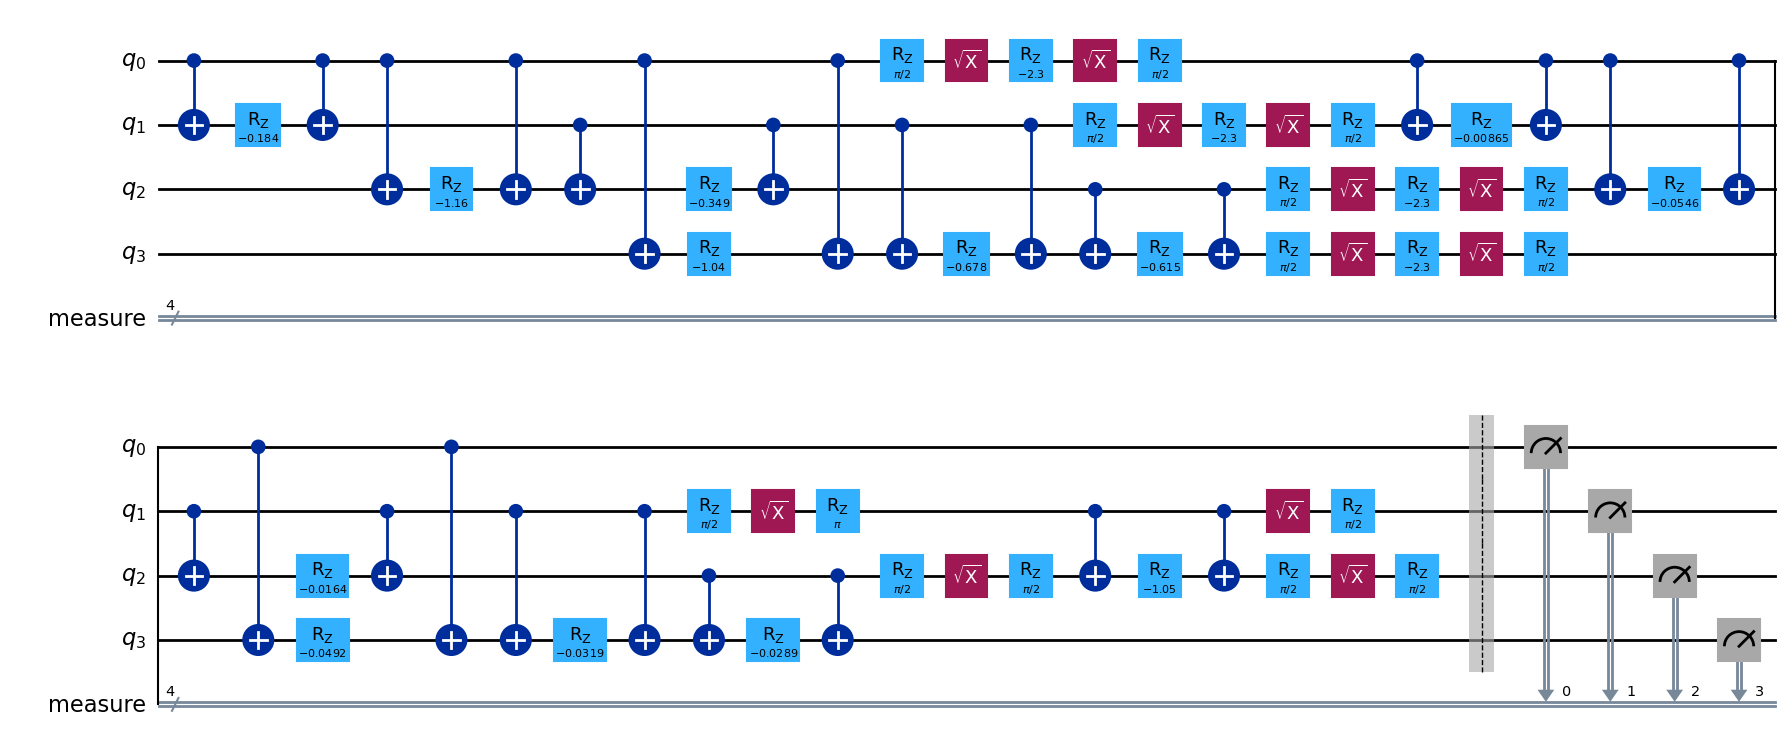

In [121]:
origin_qiskit.draw('mpl')

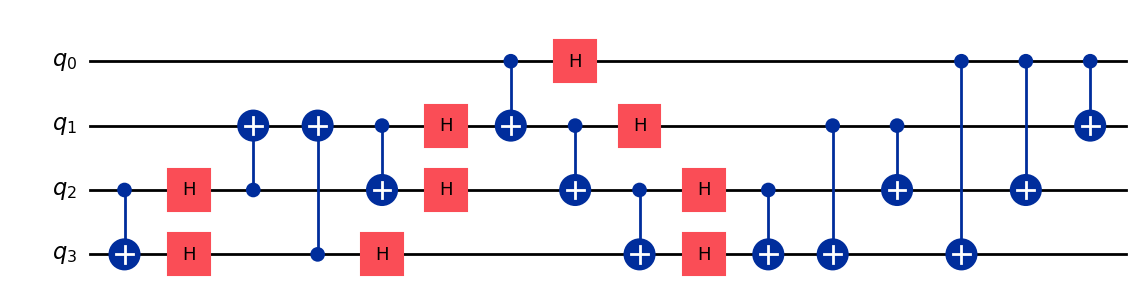

In [122]:
append_clifford.draw('mpl')

In [123]:
opt_qc.count_ops()

OrderedDict([('rz', 17),
             ('cx', 13),
             ('h', 13),
             ('measure', 4),
             ('barrier', 1)])

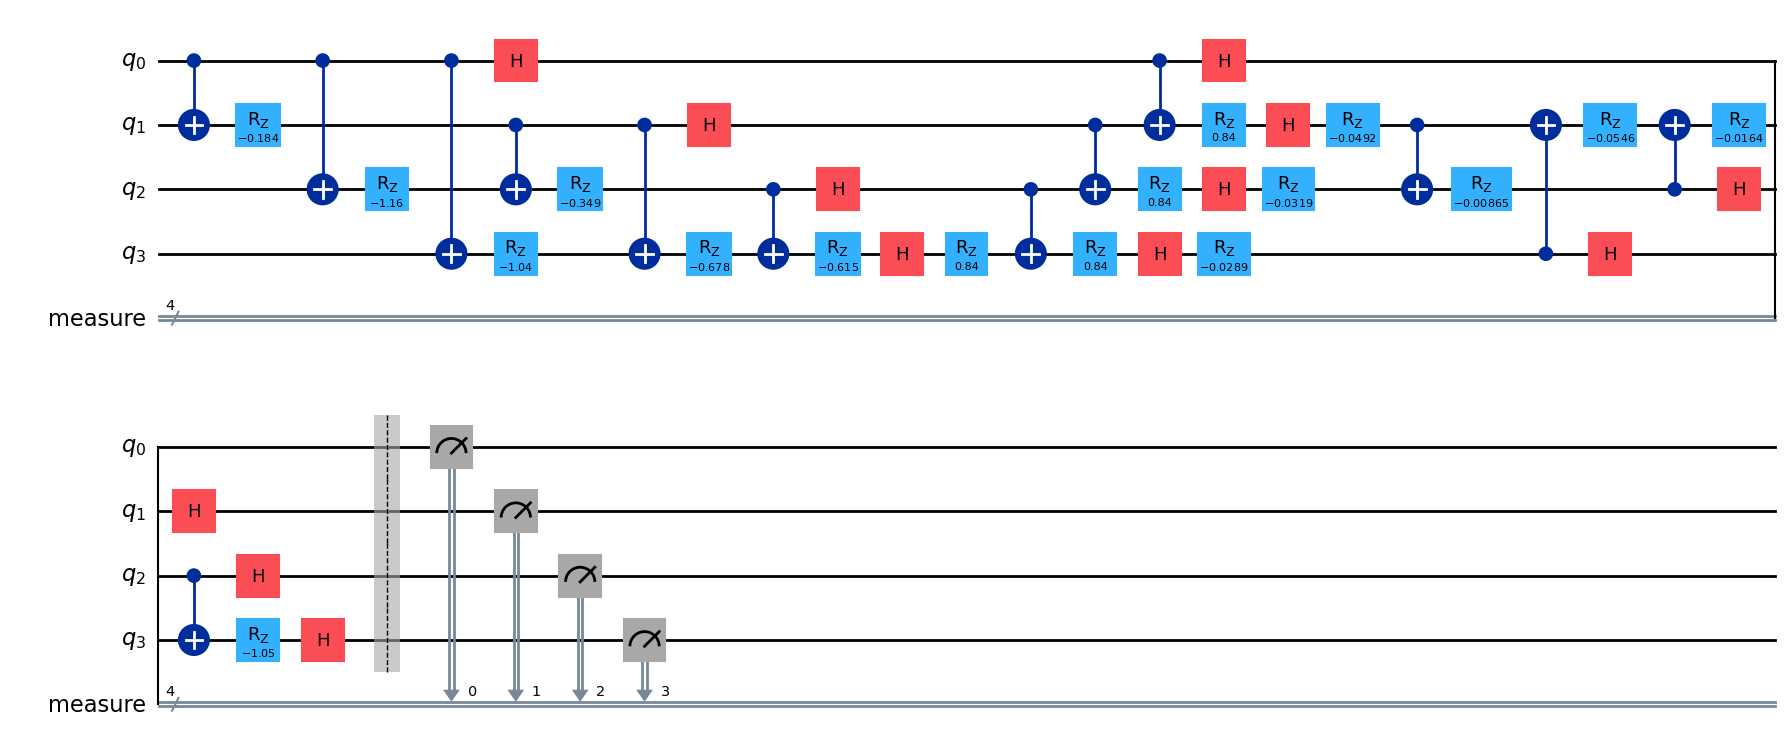

In [124]:
opt_qc.draw('mpl')

In [125]:
cnot_network = extract_CNOT_network(append_clifford)

In [126]:
#Run the original circuit on a noiseless simulator:
simulator = AerSimulator()
origin_result = simulator.run(origin_qiskit, shots = 10000).result()

In [127]:
def get_top_k_values(input_dict, k):
    # Sort the dictionary by values in descending order and return the top k items
    sorted_items = sorted(input_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_items[:k]

In [128]:
origin_probs= origin_result.get_counts()

In [129]:
top_k_states_origin = get_top_k_values(origin_probs, 20)
print(top_k_states_origin)

[('0000', 3590), ('0110', 1452), ('0010', 1012), ('0100', 941), ('1000', 713), ('0001', 684), ('0111', 286), ('1110', 269), ('1010', 217), ('0101', 195), ('0011', 188), ('1100', 179), ('1001', 133), ('1111', 52), ('1011', 52), ('1101', 37)]


In [130]:
#Run the optimized circuit on a noiseless simulator:

opt_result = simulator.run(opt_qc, shots = 10000).result()

In [131]:
dag = circuit_to_dag(cnot_network)
updated_states = {}

updated_probs = update_probabilities(opt_result.get_counts(), dag)


In [132]:
from qiskit.quantum_info.analysis import hellinger_fidelity

In [133]:
hellinger_fidelity(origin_probs, updated_probs)

0.6651672395087762

In [134]:
top_k_states_origin = get_top_k_values(origin_probs, 20)
print(top_k_states_origin)

[('0000', 3590), ('0110', 1452), ('0010', 1012), ('0100', 941), ('1000', 713), ('0001', 684), ('0111', 286), ('1110', 269), ('1010', 217), ('0101', 195), ('0011', 188), ('1100', 179), ('1001', 133), ('1111', 52), ('1011', 52), ('1101', 37)]


In [135]:
top_k_states_updated = get_top_k_values(updated_probs, 20)
print(top_k_states_updated)

[('0011', 2602), ('0001', 1567), ('0000', 1096), ('0101', 892), ('0110', 758), ('0111', 732), ('0100', 508), ('1011', 475), ('1001', 336), ('1000', 245), ('0010', 229), ('1101', 182), ('1110', 135), ('1111', 134), ('1100', 81), ('1010', 28)]


In [31]:
# import numpy as np
# from scipy.sparse import csr_matrix
# from qiskit.quantum_info import SparsePauliOp

# # Assuming 'sparse_matrix' is your sparse matrix of a pure state vector
# # Convert the sparse matrix to a dense array (assuming it's a column vector)
# state_vector = adapt_qaoa_solution['all_den_mats'].toarray().flatten()  # Flatten if it's a column vector

# # Create the density matrix
# density_matrix = np.outer(state_vector, state_vector.conj())

# # Ensure it is a valid density matrix
# # Check Hermitian property
# # print(np.allclose(density_matrix, density_matrix.conj().T))
# # Check trace
# # print(np.isclose(np.trace(density_matrix), 1.0))

# test_paulis = SparsePauliOp.from_operator(density_matrix).paulis[1:]
# test_params = SparsePauliOp.from_operator(density_matrix).coeffs.real[1:]

In [32]:
# state_vector = dynamic_adapt_qaoa_solution['all_den_mats'].toarray().flatten()  # Flatten if it's a column vector

# # Create the density matrix
# density_matrix = np.outer(state_vector, state_vector.conj())
# print(density_matrix.shape)
# test_paulis = SparsePauliOp.from_operator(density_matrix).paulis[1:]
# test_params = SparsePauliOp.from_operator(density_matrix).coeffs.real[1:]